Dataset loaded successfully.
         time  lat  lon      NDVI  Precipitation
0  2000-01-31    0    0  0.599491       0.480977
1  2000-01-31    0    1  0.811728       0.616283
2  2000-01-31    0    2  0.981863       0.641640
3  2000-01-31    0    3  0.372081       0.959300
4  2000-01-31    0    4  0.928539       0.011036
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   time           120000 non-null  object 
 1   lat            120000 non-null  int64  
 2   lon            120000 non-null  int64  
 3   NDVI           120000 non-null  float64
 4   Precipitation  120000 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 4.6+ MB
None
                lat           lon           NDVI  Precipitation
count  120000.00000  120000.00000  120000.000000  120000.000000
mean       49.50000      49.50000       0.500646       0.

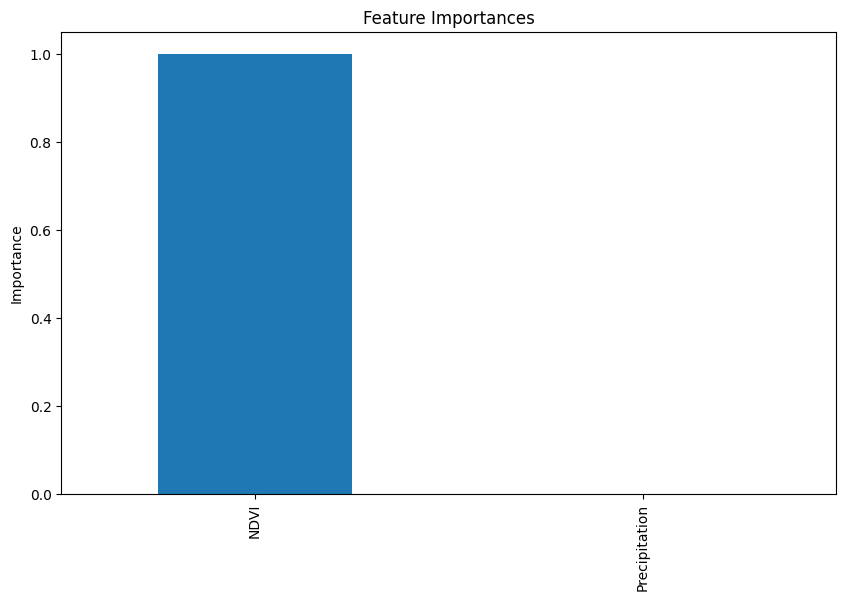

Training LSTM with Modified Architecture...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9203 - loss: 0.1638
Epoch 2/20
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9966 - loss: 0.0105
Epoch 3/20
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9969 - loss: 0.0080
Epoch 4/20
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9974 - loss: 0.0072
Epoch 5/20
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9973 - loss: 0.0063
Epoch 6/20
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9974 - loss: 0.0061
Epoch 7/20
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9979 - loss: 0.0054
Epoch 8/20
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9971 - loss: 0.0063
Epoch 9/20
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9975 - loss: 0.0056
Epoch 10/20
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9976 - loss: 0.0054
Epoch 11/20
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9977 - loss: 0.0052
Epoch 12/20
3000/30

In [1]:
### Step 1: Import Required Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium

### Step 2: Load the Dataset
data = pd.read_csv("drought_dataset.csv")
print("Dataset loaded successfully.")

# Display basic dataset information
print(data.head())
print(data.info())
print(data.describe())

### Step 3: Preprocess the Data
# Define drought condition based on NDVI and Precipitation thresholds
data['drought_condition'] = ((data['NDVI'] < 0.3) & (data['Precipitation'] < 50)).astype(int)

# Split features (X) and target variable (y)
X = data.drop(['drought_condition', 'time', 'lat', 'lon'], axis=1)
y = data['drought_condition']

# Normalize feature values
X = (X - X.min()) / (X.max() - X.min())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Step 4: Train Random Forest Model with Hyperparameter Tuning
print("Training Random Forest with Hyperparameter Tuning...")
rf = RandomForestClassifier(random_state=42)
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}
rf_grid = GridSearchCV(rf, rf_params, cv=3, scoring='f1', n_jobs=-1)
rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_
print("Best Random Forest Parameters:", rf_grid.best_params_)

### Step 5: Analyze Feature Importance
print("Analyzing Feature Importance...")
feature_importances = pd.Series(rf_best.feature_importances_, index=X.columns).sort_values(ascending=False)
print(feature_importances)
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar')
plt.title("Feature Importances")
plt.ylabel("Importance")
plt.show()

### Step 6: Train LSTM Model with Modified Architecture
print("Training LSTM with Modified Architecture...")
X_train_lstm = np.expand_dims(X_train.values, axis=2)
X_test_lstm = np.expand_dims(X_test.values, axis=2)

lstm = Sequential([
    LSTM(100, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dense(1, activation='sigmoid')
])

lstm.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
lstm.fit(X_train_lstm, y_train, epochs=20, batch_size=32, verbose=1)



In [2]:
### Step 7: Evaluate Models
print("Evaluating models...")
def evaluate_model(model, X_test, y_test, is_lstm=False):
    y_pred = model.predict(X_test)
    if is_lstm:
        y_pred = (y_pred > 0.5).astype(int)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"Accuracy: {acc:.2f}")
    print(f"Precision: {prec:.2f}")
    print(f"Recall: {rec:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

print("Random Forest Performance:")
evaluate_model(rf_best, X_test, y_test)

print("LSTM Performance:")
evaluate_model(lstm, X_test_lstm, y_test, is_lstm=True)


Evaluating models...
Random Forest Performance:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16792
           1       1.00      1.00      1.00      7208

    accuracy                           1.00     24000
   macro avg       1.00      1.00      1.00     24000
weighted avg       1.00      1.00      1.00     24000

LSTM Performance:
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16792
           1       1.00      1.00      1.00      7208

    accuracy                           1.00     24000
   macro avg       1.00      1.00      1.00     24000
weighted avg       1.00      1.00      1.00     24000



750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


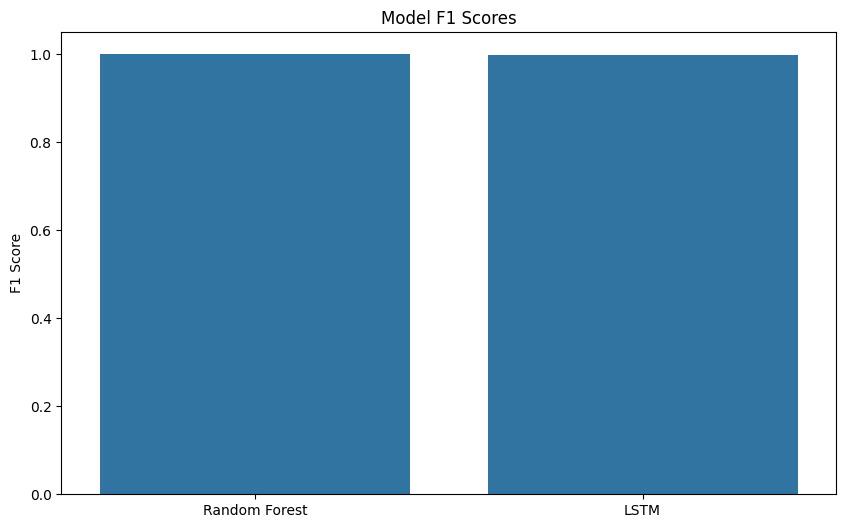

In [3]:
### Step 8: Visualize Results
plt.figure(figsize=(10, 6))
models = ["Random Forest", "LSTM"]
metrics = [
    f1_score(y_test, rf_best.predict(X_test)),
    f1_score(y_test, (lstm.predict(X_test_lstm) > 0.5).astype(int))
]
sns.barplot(x=models, y=metrics)
plt.title("Model F1 Scores")
plt.ylabel("F1 Score")
plt.show()

Generating scatter plot for precipitation levels...


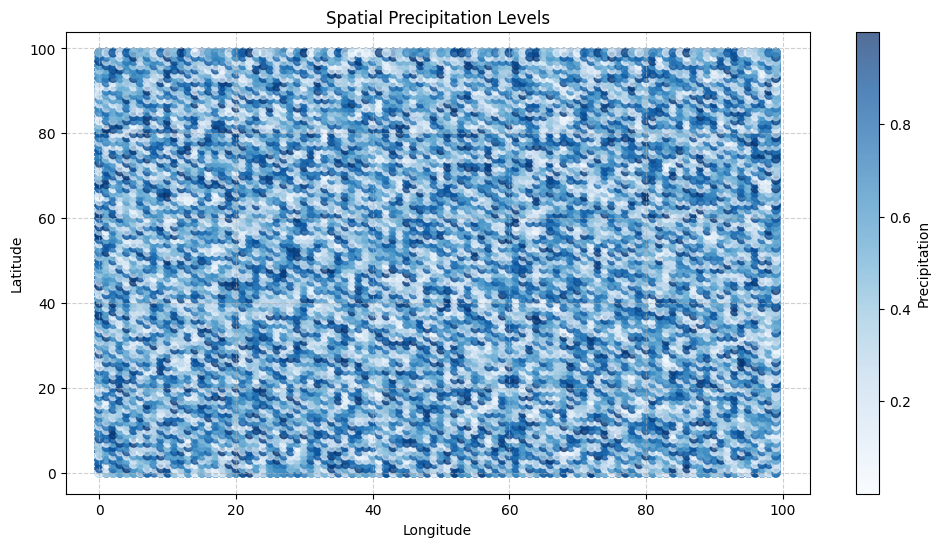

Loading shapefile from: shapefiles/ne_110m_admin_0_countries_lakes.shp
Shapefile loaded successfully!
Plotting drought conditions on a map...


<Figure size 1200x800 with 0 Axes>

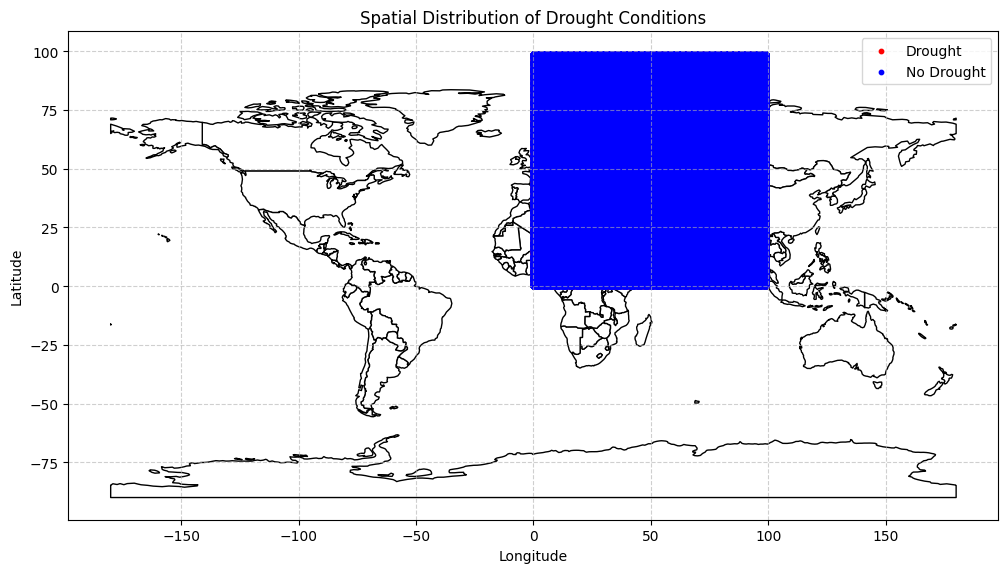

Creating an interactive map for visualization...
Interactive map saved as 'drought_map.html'.


In [9]:
# Scatter Plot for Precipitation Levels
print("Generating scatter plot for precipitation levels...")
plt.figure(figsize=(12, 6))
scatter = plt.scatter(
    data['lon'], data['lat'], c=data['Precipitation'], cmap='Blues', alpha=0.7
)
plt.colorbar(scatter, label="Precipitation")
plt.title("Spatial Precipitation Levels")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Define the zip file and extraction paths
zip_file_path = "1.zip"
extract_to = "shapefiles"

# Extract the zip file
if not os.path.exists(extract_to):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Extracted shapefiles to '{extract_to}'.")

# Dynamically find the shapefile path
shapefile_path = None
for root, dirs, files in os.walk(extract_to):
    for file in files:
        if file.endswith(".shp"):
            shapefile_path = os.path.join(root, file)
            break

if shapefile_path is None:
    raise FileNotFoundError("Shapefile (.shp) not found in the extracted files.")

# Load the world shapefile
try:
    print(f"Loading shapefile from: {shapefile_path}")
    world = gpd.read_file(shapefile_path)
    print("Shapefile loaded successfully!")
except Exception as e:
    print(f"Error loading shapefile: {e}")
    raise

# Spatial map of drought conditions
print("Plotting drought conditions on a map...")
plt.figure(figsize=(12, 8))
ax = world.plot(color='white', edgecolor='black', figsize=(12, 8))

# Plot drought and non-drought points
gdf[gdf['drought_condition'] == 1].plot(
    ax=ax, color='red', markersize=10, label='Drought'
)
gdf[gdf['drought_condition'] == 0].plot(
    ax=ax, color='blue', markersize=10, label='No Drought'
)
plt.legend()
plt.title("Spatial Distribution of Drought Conditions")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Export an interactive map for visualization
print("Creating an interactive map for visualization...")
m = folium.Map(location=[data['lat'].mean(), data['lon'].mean()], zoom_start=6)
for _, row in data.iterrows():
    color = 'red' if row['drought_condition'] == 1 else 'blue'
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=5,
        color=color,
        fill=True,
        fill_color=color
    ).add_to(m)

# Save the interactive map as an HTML file
map_file = "drought_mapping.html"
m.save(map_file)
print(f"Interactive map saved as '{map_file}'.")
